# Source

http://jmcauley.ucsd.edu/data/amazon/

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import Tokenizer, Word2Vec

# these imports are how we build and manager our data science processes: cleaning data, preparing a model,
# executing the model, and evaluating the model.
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
from sklearn.utils import resample
%matplotlib inline

In [2]:
# we use a set of constants for clarity and simplicity in managing the notebook.
# this allows you to refer back to this cell at any time if you need to either confirm or modify any of these values.

DATA_NAME = "Cell_Phones_and_Accessories_5.json"
APP_NAME = "Sentiment Analysis with Amazon Reviews Exercise"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 12
RF_MAX_DEPTH = 8
RF_NUM_BINS = 32

In [3]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(sc)

In [4]:
amznElectronics = sqlContext.read.json(DATA_NAME)

In [5]:
#amznElectronics.sample(fraction=.33, withReplacement=True)

In [6]:
print(f"Dataset shape is {amznElectronics.count():d} rows by {len(amznElectronics.columns):d} columns.")

Dataset shape is 194439 rows by 9 columns.


In [7]:
amznElectronics.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [8]:
amznElectronics.registerTempTable('reviews')

In [9]:
sqlContext.sql("select overall, count(overall) as reviewCount from reviews group by overall order by overall desc").show()

+-------+-----------+
|overall|reviewCount|
+-------+-----------+
|    5.0|     108664|
|    4.0|      39993|
|    3.0|      21439|
|    2.0|      11064|
|    1.0|      13279|
+-------+-----------+



In [10]:
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())

amznElectronics = amznElectronics.withColumn("overall_recode",udf(amznElectronics.overall))

([<matplotlib.axis.XTick at 0x7f5a28cbf2b0>,
 <a list of 2 Text xticklabel objects>)

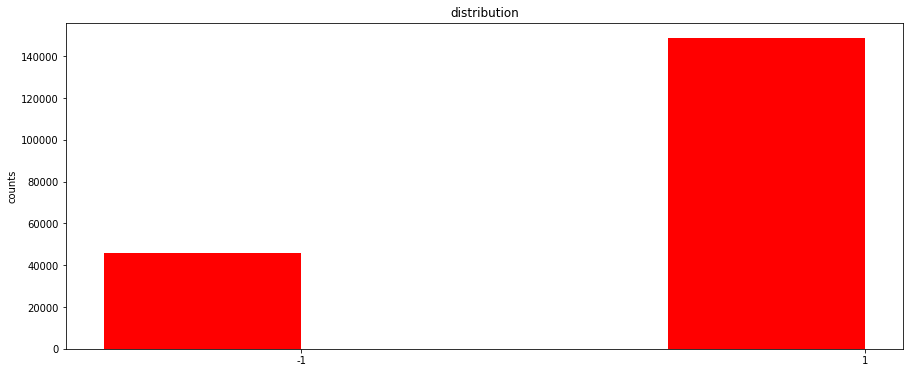

In [11]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = amznElectronics.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)

In [12]:
## Downsampling is not very effective - results in 6% loss in accuracy

# # Create fraction to pass into sample selection
# fraction = amznElectronics[amznElectronics['overall_recode']==-1].count()/amznElectronics[amznElectronics['overall_recode']==1].count()

# # Sample the positive reviews
# amznElectronics=amznElectronics.sampleBy('overall_recode', fractions = {-1:1, 1: fraction})

# plt.rcParams['figure.figsize'] = (15, 6)
 
# statuses = amznElectronics.groupBy('overall_recode').count().collect()

# categories = [i[0] for i in statuses]
# counts = [i[1] for i in statuses]
 
# ind = np.array(range(len(categories)))
# width = 0.35
# plt.bar(ind, counts, width=width, color='r')
 
# plt.ylabel('counts')
# plt.title('distribution')
# plt.xticks(ind + width/2., categories)

In [13]:
amznElectronics.select("overall", "overall_recode", "summary", "reviewText").show(10)

+-------+--------------+--------------------+--------------------+
|overall|overall_recode|             summary|          reviewText|
+-------+--------------+--------------------+--------------------+
|    4.0|             1|          Looks Good|They look good an...|
|    5.0|             1|Really great prod...|These stickers wo...|
|    5.0|             1|      LOVE LOVE LOVE|These are awesome...|
|    4.0|             1|               Cute!|Item arrived in g...|
|    5.0|             1|leopard home butt...|awesome! stays on...|
|    3.0|            -1|                Cute|These make using ...|
|    5.0|             1|   best thing ever..|Came just as desc...|
|    1.0|            -1|     not a good Idea|it worked for the...|
|    5.0|             1|          Solid Case|Good case, solid ...|
|    5.0|             1|        Perfect Case|This is a fantast...|
+-------+--------------+--------------------+--------------------+
only showing top 10 rows



In [14]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(amznElectronics)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf=word2Vec.transform(tokenizer)

In [15]:
w2vdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_recode: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)



In [16]:
w2vdf.select("overall_recode", "reviewText", "tokenized_text", "w2v_vector").show(10)

+--------------+--------------------+--------------------+--------------------+
|overall_recode|          reviewText|      tokenized_text|          w2v_vector|
+--------------+--------------------+--------------------+--------------------+
|             1|They look good an...|[they, look, good...|[-0.0684834776597...|
|             1|These stickers wo...|[these, stickers,...|[-0.0627381536469...|
|             1|These are awesome...|[these, are, awes...|[-0.0387413898647...|
|             1|Item arrived in g...|[item, arrived, i...|[0.00320847414653...|
|             1|awesome! stays on...|[awesome!, stays,...|[-0.0262232812043...|
|            -1|These make using ...|[these, make, usi...|[-0.0305492765037...|
|             1|Came just as desc...|[came, just, as, ...|[-0.0205116038234...|
|            -1|it worked for the...|[it, worked, for,...|[-0.0076959951780...|
|             1|Good case, solid ...|[good, case,, sol...|[-0.0727871617789...|
|             1|This is a fantast...|[th

In [17]:
# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [18]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [19]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.232544
Accuracy = 0.767456
